# load smile ADCP data and inspect

To do:
 
- [ ] add attributes
- [ ] 


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray  # noqa

import scipy.io as sio

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

---

## currents

In [2]:
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/smile"
adcp_file = os.path.join(root_dir, "raw/SMILE_AWAC_201907_202205.mat")

In [3]:
my_struct = sio.loadmat(adcp_file)

In [4]:
list(my_struct)

['__header__', '__version__', '__globals__', 'smile']

In [5]:
my_struct["smile"].dtype

dtype([('adcp', 'O')])

In [6]:
my_struct["smile"]["adcp"][0][0].dtype

dtype([('time', 'O'), ('a1', 'O'), ('a2', 'O'), ('a3', 'O'), ('ve', 'O'), ('vn', 'O'), ('vu', 'O'), ('battery', 'O'), ('heading', 'O'), ('ptich', 'O'), ('roll', 'O'), ('pressure', 'O'), ('temperature', 'O'), ('BI', 'O'), ('maskbin', 'O'), ('ssc', 'O'), ('vel', 'O'), ('binpos', 'O')])

In [7]:
d = my_struct["smile"]["adcp"][0][0]

# matlab time
mtime=d["time"][0][0][:].squeeze()
# convert to datetime
# https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python
time = pd.to_datetime(mtime-719529, unit='D').to_series().dt.round("15T")
# there is a 15min offset in the timeline, e.g. data is every 30 minutes but starts at 0h15min
# we therefore cannot round every 30minutes

ve=d["ve"][0][0]
vn=d["vn"][0][0]
vu=d["vu"][0][0]
vel=d["ssc"][0][0]
BI=d["BI"][0][0]
ssc=d["ssc"][0][0]

a1=d["a1"][0][0]
a2=d["a2"][0][0]
a3=d["a3"][0][0]

battery=d["battery"][0][0].squeeze()
heading=d["heading"][0][0].squeeze()
pitch=d["ptich"][0][0].squeeze()
roll=d["roll"][0][0].squeeze()
pressure=d["pressure"][0][0].squeeze()
temperature=d["temperature"][0][0].squeeze()

binpos=d["binpos"][0][0].squeeze()

In [23]:
ds = xr.Dataset(dict(ve=(("time","bin"), ve, {"long_name": "Eastward Velocity", "units": "meters per seconds"}),
                     vn=(("time","bin"), vn, {"long_name": "Northward Velocity", "units": "meters per seconds"}),
                     vu=(("time","bin"), vu, {"long_name": "Upward Velocity", "units": "meters per seconds"}),
                     vel=(("time","bin"), vel, {"long_name": "Velocity", "units": "meters per seconds"}),
                     bi=(("time","bin"), BI, {"long_name": "Bascatter Intensity", "units": "unknown"}),
                     ssc=(("time","bin"), ssc),
                     a1=(("time","bin"), a1),
                     a2=(("time","bin"), a2),
                     a3=(("time","bin"), a3),
                     battery=(("time",), battery),
                     heading=(("time",), heading),
                     pitch=(("time",), pitch),
                     roll=(("time",), roll),
                     pressure=(("time",), pressure),
                     temperature=(("time",), temperature),
                    ),
                coords=dict(time=("time", time),
                            bin_position=("bin", binpos),
                           )
               )

ds_nomask = ds

# mask with the backscatter
ds = ds.where(ds.bi.max("bin")>-500)
for v in ds:
    if len(ds[v].dims)==2:
        #ds[v] = ds[v].where(ds.bi>-500) # too strong: backscatter may be low but velocity seems ok
        ds[v] = ds[v].where(ds.bin_position<ds.pressure-2)
# mask with pressure
ds = ds.where(ds.pressure>5)

ds

<xarray.Dataset>
Dimensions:       (time: 32617, bin: 40)
Coordinates:
  * time          (time) datetime64[ns] 2019-07-12 ... 2022-05-06T11:45:00
    bin_position  (bin) float64 0.9 1.4 1.9 2.4 2.9 ... 18.4 18.9 19.4 19.9 20.4
Dimensions without coordinates: bin
Data variables: (12/15)
    ve            (time, bin) float64 -0.086 -0.068 -0.122 ... nan nan nan
    vn            (time, bin) float64 -0.022 -0.097 0.048 0.089 ... nan nan nan
    vu            (time, bin) float64 -0.023 -0.019 0.002 -0.004 ... nan nan nan
    vel           (time, bin) float64 0.000222 0.0002314 0.0002449 ... nan nan
    bi            (time, bin) float64 -92.09 -91.64 -91.03 ... nan nan nan
    ssc           (time, bin) float64 0.000222 0.0002314 0.0002449 ... nan nan
    ...            ...
    battery       (time) float64 13.4 13.4 13.4 13.4 ... 10.7 10.7 10.7 10.7
    heading       (time) float64 356.7 356.6 356.8 356.8 ... 160.3 160.9 160.8
    pitch         (time) float64 1.0 0.9 0.7 0.9 0.7 0.9 ... 0.7 0.9 0.8 0.7 0.6
    roll          (time) float64 -0.5 -0.6 -0.5 -0.5 -0.4 ... 0.2 0.3 0.1 0.2
    pressure      (time) float64 12.23 12.34 12.62 13.1 ... 15.99 16.34 16.52
    temperature   (time) float64 18.75 18.73 18.74 18.74 ... 12.49 12.59 12.65

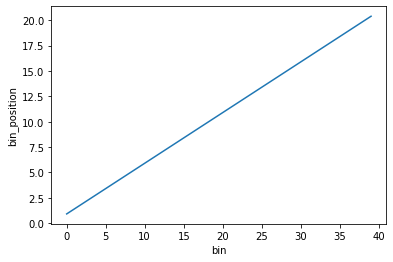

In [9]:
ds.bin_position.plot()

#### Highlight times when data is offset by 15 minutes

In [10]:
print(np.unique(ds.time.dt.minute))

_time = ds.time.where(ds.time.dt.minute.isin([15,45])).dropna("time")
_time.min().values, _time.max().values

[ 0 15 30 45]


(numpy.datetime64('2021-05-20T09:15:00.000000000'),
 numpy.datetime64('2022-05-06T11:45:00.000000000'))

#### time interval time series

[5.00000e-01 1.50000e+00 2.00000e+00 2.50000e+00 3.00000e+00 3.50000e+00
 4.00000e+00 4.50000e+00 5.50000e+00 6.00000e+00 4.78000e+02 1.54050e+03
 2.15150e+03 4.17275e+03]


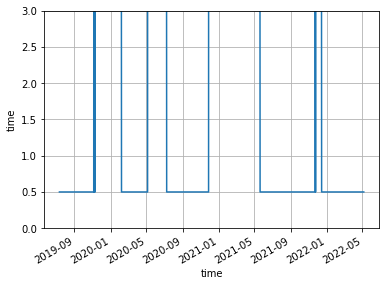

In [11]:
da = ds.time.diff("time")/pd.Timedelta("1H")
print(np.unique(da))

fig, ax = plt.subplots(1,1)
da.plot()
ax.set_ylim(0,3)
ax.grid()

#### check backscatter and pressure

In [12]:
#ds_nomask.pressure.hvplot(color="orange")
ds.pressure.hvplot()

:Curve   [time]   (pressure)

In [13]:
#_da = da.assign_coords(bin=np.arange(da.bin.size)).drop("bin_position")
#_da.hvplot.quadmesh("time", "bin", rasterize=True,)

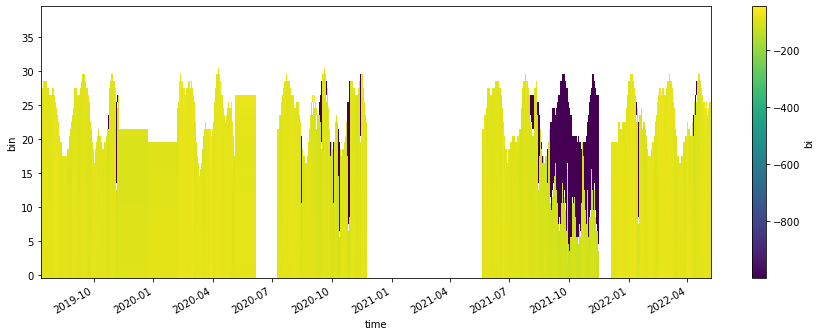

In [14]:
da = ds["bi"]
#da = da.where(da>-500)
da.plot(x="time", figsize=(15,5))

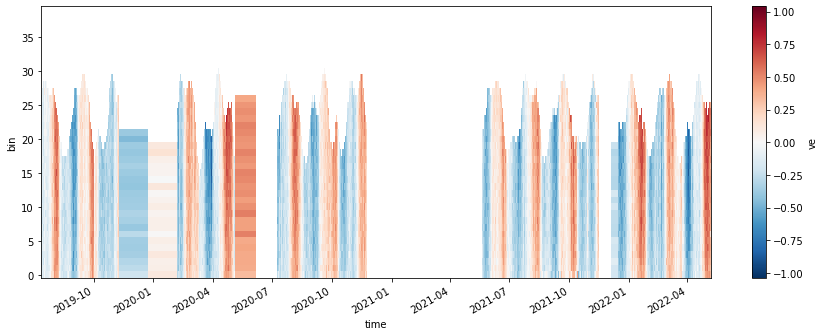

In [15]:
da = ds["ve"]
#da = da.where(da>-500)
da.plot(x="time", figsize=(15,5))


### inspect period of decreasing backscatter

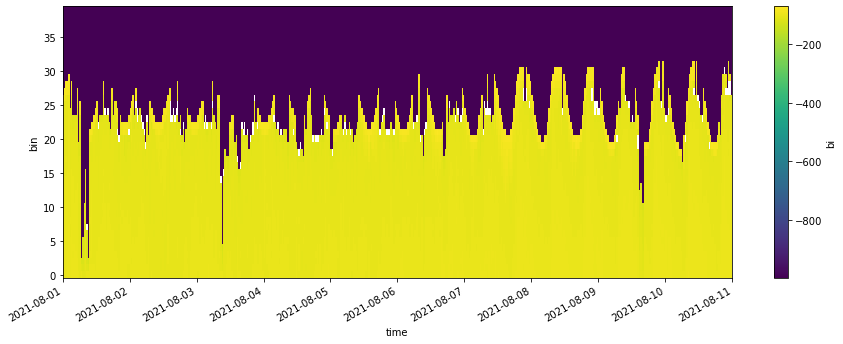

In [16]:
# older time
#_ds = ds_nomask.sel(time=slice("2019/09/01", "2019/09/10"))

#_ds = ds_nomask.sel(time=slice("2021/08/01", "2021/10/01"))
_ds = ds_nomask.sel(time=slice("2021/09/01", "2021/09/10"))
_ds = ds_nomask.sel(time=slice("2021/08/01", "2021/08/10"))

_ds.bi.plot(x="time", figsize=(15,5))

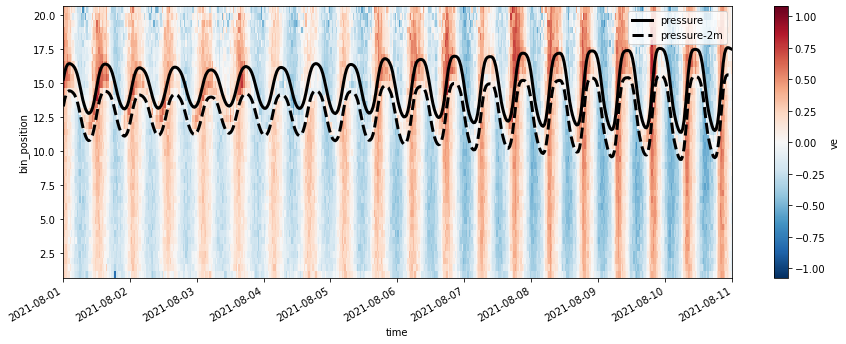

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.ve.plot(x="time", y="bin_position")

ax.plot(_ds.time,_ds.pressure, color="k", lw=3, label="pressure")
ax.plot(_ds.time,_ds.pressure-2, color="k", ls="--", lw=3, label="pressure-2m")
ax.legend()

## resample on a regular timeline and fill gaps

In [18]:
da = (ds.ve.resample(time="15T").median()
      .interpolate_na("time", max_gap=pd.Timedelta("30T"))
     )

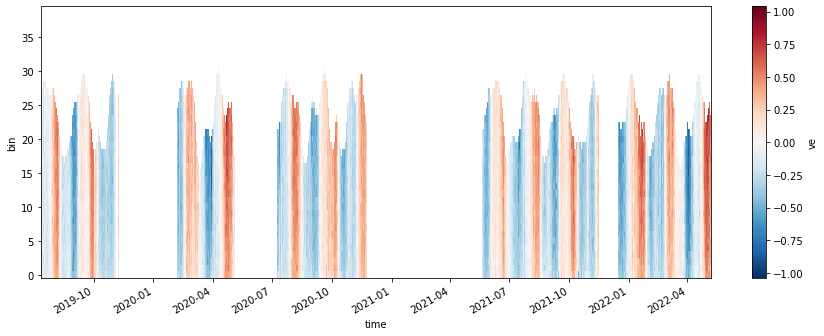

In [19]:
da.plot(x="time", figsize=(15,5))

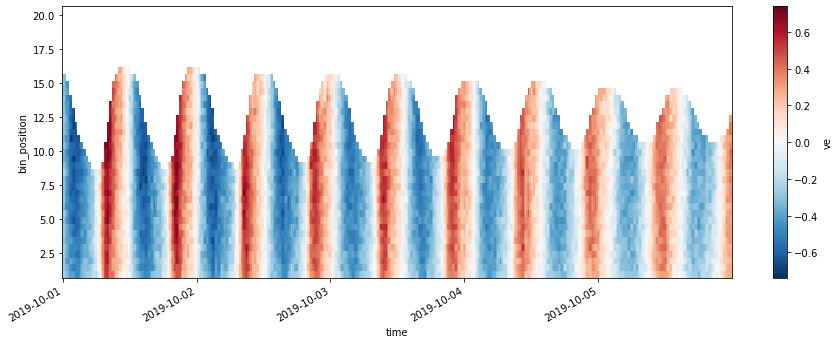

In [20]:
da.sel(time=slice("2019/10/01", "2019/10/5")).plot(x="time", y="bin_position", figsize=(15,5))

## store data

In [22]:
ds.to_netcdf(os.path.join(root_dir, "adcp.nc"))

In [2]:
# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
campaign="taos0_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque
